In [13]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.ylim((0,0.2))
    plt.show()
    plt.close()

In [35]:
import csv
import pprint
from sklearn.metrics import accuracy_score

def est(clustering_result):
    all_cnt = 0
    ok_cnt = 0
    count = len(clustering_result)
    result_table = [[1 if i == j else 0 for j in clustering_result] for i in clustering_result]
    sim_table = [[0 for _ in clustering_result] for _ in clustering_result]
    with open("./data/note_sims/sim.csv", newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            s = int(row[0])
            t = int(row[1])
            sim_table[s][t] = 1
            sim_table[t][s] = 1
            all_cnt += 1
            if clustering_result[s] == clustering_result[t]:
                ok_cnt += 1

    print("\n===== similarity =====")
    print(f"true positive rate = {ok_cnt / all_cnt}")
    print(f"accuracy = {accuracy_score(sum(sim_table, []), sum(result_table, []))}")
    

    all_cnt = 0
    ok_cnt = 0
    with open("./data/note_sims/not_sim.csv", newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            s = int(row[0])
            t = int(row[1])
            all_cnt += 1
            if clustering_result[s] != clustering_result[t]:
                ok_cnt += 1


    print("======= not sim ======")
    print(f"true negative rate = {ok_cnt / all_cnt}")
    print("======================\n")
    # print(f"accuracy = {accuracy_score()}")

['./data/_json/feature_vector/song155_fv.json']
array([[-0.27376769, -0.97408202, -0.4508071 ],
       [ 0.51610796,  1.59077359,  0.25480402],
       [-0.1458526 ,  0.76685193, -0.4508071 ],
       ...,
       [ 1.53942863,  1.06279681,  4.01806333],
       [ 1.69612461,  1.99926089,  4.48847074],
       [-0.187425  ,  0.0999339 , -0.4508071 ]])
[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000002]
eps = 0.05

===== similarity =====
true positive rate = 0.1320754716981132
accuracy = 0.9016382613291055
======= not sim ======
true negative rate = 0.7946428571428571

eps = 0.1

===== similarity =====
true positive rate = 0.07547169811320754
accuracy = 0.9272195798652398
======= not sim ======
true negative rate = 0.8839285714285714

eps = 0.1500000000000000

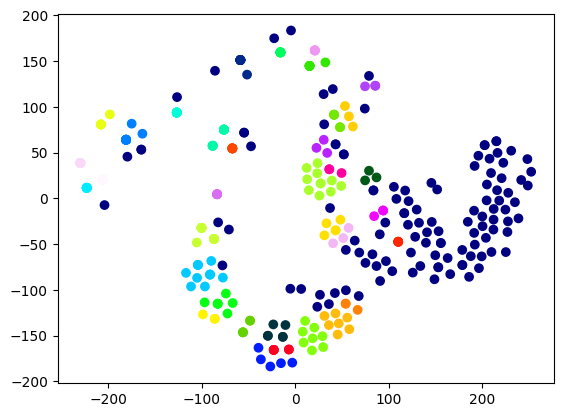

In [52]:
# %pip install sklearn
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import os
import json
import glob
import csv
import pprint
import matplotlib.pyplot as plt

save_dir = "./data/_json/0724/clustering_result"
os.makedirs(save_dir, exist_ok=True)
save_file_name = "clustering_data.csv"
with open(f"{save_dir}/{save_file_name}", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id","x", "y", "label"])

notes_file_paths = glob.glob("./data/_json/feature_vector/*.json")
notes_file_paths = [f for f in notes_file_paths if "155" in f]
pprint.pprint(notes_file_paths)
for eps,file_path in enumerate(notes_file_paths):
    data = None
    id = None
    with open(file_path, newline="") as f:
        content = json.load(f)        
        data = preprocessing.StandardScaler().fit_transform(np.array(content["data"]))
        id = content["id"]

    pprint.pprint(data)
    if data is None or id is None:
        print(f"{file_path} file is not found")
        continue
    # k = 2 * len(data[0]) - 1 # k=2*{dim(dataset)} - 1
    # get_kdist_plot(X=data, k=k)
    # クラスタリング
    range_max = 1
    range_step = 20
    range_min = range_max/range_step
    step = range_max/range_step
    now = range_min
    rng = []
    for i in range(range_step):
        rng.append(now)
        now += step
    print(rng)

    for eps in rng:
        clustering_result = DBSCAN(eps=eps, min_samples=3).fit_predict(data)
        clustering_result += 1
        # pprint.pprint(clustering_result)
        print(f"eps = {eps}")
        est(clustering_result)

    # 0.003250035
    clustering_result = DBSCAN(eps=0.003250035, min_samples=3).fit_predict(data)
    clustering_result += 1
    # 次元削減
    tsne = TSNE(n_components=2, random_state=0)
    data_tsne = tsne.fit_transform(data)
    
    plt.scatter(data_tsne[:,0],data_tsne[:,1], c=clustering_result, cmap="gist_ncar")
    plt.show()

    # 各区間ごとのデータ
    # for d in zip(data_tsne, clustering_result):
    #     print(d)
    clustering_data = [[id,float(pos[0]), float(pos[1]), int(l)]for (pos, l) in zip(data_tsne, clustering_result)]

    with open(f"{save_dir}/{save_file_name}", "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(clustering_data)